# Transformer Evaluation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from pathlib import Path

wd = Path(os.path.dirname(os.path.abspath("__file__"))).parent.resolve()
sys.path.append(str(wd))

import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from datetime import datetime, timedelta
from src.models.auction_transformer import AuctionTransformer
from src.models.inference import predict_dataframe

pd.options.display.max_columns = None
pd.options.display.width = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
prediction_time = datetime.strptime("2025-09-09 20:00:00", "%Y-%m-%d %H:%M:%S")

mappings_dir = '../generated/mappings'

with open(os.path.join(mappings_dir, 'item_to_idx.json'), 'r') as f:
        item_to_idx = json.load(f)

with open(os.path.join(mappings_dir, 'context_to_idx.json'), 'r') as f:
    context_to_idx = json.load(f)
    
with open(os.path.join(mappings_dir, 'bonus_to_idx.json'), 'r') as f:
    bonus_to_idx = json.load(f)

with open(os.path.join(mappings_dir, 'modtype_to_idx.json'), 'r') as f:
    modtype_to_idx = json.load(f)

feature_stats = torch.load('../generated/feature_stats.pt')

time_left_mapping = {
    'VERY_LONG': 48,
    'LONG': 12,
    'MEDIUM': 2,
    'SHORT': 0.5
}

In [4]:
from src.data.utils import load_auctions_from_sample

data_dir = '../data/sample/'

df_auctions = load_auctions_from_sample(data_dir, prediction_time, time_left_mapping, item_to_idx, context_to_idx, bonus_to_idx, modtype_to_idx)

print("Auctions shape:", df_auctions.shape)
df_auctions.head()

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 15/15 [00:00<00:00, 58254.22it/s]

../data/sample/2025/09/07/20250907T20.json


../data/sample/2025/09/07/20250907T21.json
../data/sample/2025/09/07/20250907T22.json
../data/sample/2025/09/07/20250907T23.json
../data/sample/2025/09/08/20250908T00.json
../data/sample/2025/09/08/20250908T01.json
../data/sample/2025/09/08/20250908T02.json
../data/sample/2025/09/08/20250908T03.json
../data/sample/2025/09/08/20250908T04.json
../data/sample/2025/09/08/20250908T05.json
../data/sample/2025/09/08/20250908T06.json
../data/sample/2025/09/08/20250908T07.json
../data/sample/2025/09/08/20250908T08.json
../data/sample/2025/09/08/20250908T09.json
../data/sample/2025/09/08/20250908T10.json
../data/sample/2025/09/08/20250908T11.json
../data/sample/2025/09/08/20250908T12.json
../data/sample/2025/09/08/20250908T13.json
../data/sample/2025/09/08/20250908T14.json
../data/sample/2025/09/08/20250908T15.json
../data/sample/2025/09/08/20250908T16.json
../data/sample/2025/09/08/20250908T17.json
../data/sample/2025/09/08/20250908T18.json
../data/sample/2025/09/08/20250908T19.json
../data/sam

100%|██████████| 106961/106961 [00:00<00:00, 182637.29it/s]


Processing 97962 auctions
Auctions shape: (97962, 14)


,id,item_index,bid,buyout,quantity,time_left,context,bonus_lists,modifier_types,modifier_values,first_appearance,last_appearance,current_hours,hours_on_sale
0,150937614,17329,0.00,3000.99,1,48.0,0,[],[4],[982],2025-09-09 11:00:00,2025-09-09 20:00:00,9.0,0.0
1,149993423,6353,0.00,20071.87,1,12.0,2,"[902, 404]","[3, 4]","[30, 220]",2025-09-09 04:00:00,2025-09-10 04:00:00,16.0,8.0
2,151416518,8581,15983.16,16144.61,1,12.0,0,[],[4],[1734],2025-09-09 18:00:00,2025-09-10 04:00:00,2.0,8.0
3,150954030,6901,0.00,6906.54,1,48.0,13,[],[4],[2078],2025-09-09 11:00:00,2025-09-11 11:00:00,9.0,39.0
4,144990684,442,0.00,1288186.19,1,12.0,0,[],[],[],2025-09-08 00:00:00,2025-09-09 23:00:00,44.0,3.0


In [5]:
df_auctions[['current_hours', 'hours_on_sale']].describe()

,current_hours,hours_on_sale
count,97962.000000,97962.000000
mean,19.523958,16.336978
std,13.352959,12.739050
min,0.000000,0.000000
25%,10.000000,6.000000
50%,18.000000,11.000000
75%,26.000000,28.000000
max,47.000000,48.000000


In [7]:
model = AuctionTransformer.load_from_checkpoint(
    '../models/auction-transformer-quantile/epoch_epoch=01.ckpt',
    map_location=device
)

print(f'Number of model parameters: {sum(p.numel() for p in model.parameters())}')
model.eval()
print('Pre-trained Transformer model loaded successfully.')

Number of model parameters: 4094499
Pre-trained Transformer model loaded successfully.


/home/angel/miniconda3/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.5, which is newer than your current Lightning version: v2.5.4


In [ ]:
from src.models.inference import predict_dataframe

model = model.to('cuda')
df_auctions = predict_dataframe(model, df_auctions, prediction_time, feature_stats)

print("Mean hours on sale:", df_auctions['hours_on_sale'].mean())
print("Mean prediction:", df_auctions['prediction_q50'].mean())
print("Mean sale probability:", df_auctions['sale_probability'].mean())

mae = mean_absolute_error(df_auctions['hours_on_sale'], df_auctions['prediction_q50'])
print(f"Mean absolute error: {mae}")

Mean hours on sale: 16.400636091995654
Mean prediction: 17.019857501810936
Mean sale probability: 0.2711106709525534
Mean absolute error: 2.584072912893879


In [11]:
df_auctions.sample(5)

,id,item_index,bid,buyout,quantity,time_left,context,bonus_lists,modifier_types,modifier_values,first_appearance,last_appearance,current_hours,hours_on_sale,prediction_q10,prediction_q50,prediction_q90,sale_probability
5449,150416566,8061,0.0,3922.62,1,48.0,20,[436],[4],[717],2025-09-09 06:00:00,2025-09-11 06:00:00,14.0,34.0,31.60,32.95,33.79,0.15
32793,149952852,17129,0.0,769.06,1,12.0,12,"[1351, 1352, 1285]","[4, 5, 7, 8, 9, 10, 11]","[2734, 80, 8, 50803, 1811, 40, 341]",2025-09-09 04:00:00,2025-09-10 04:00:00,16.0,8.0,5.44,7.09,8.01,0.40
81950,151273716,4299,0.0,306617.05,1,48.0,13,[902],"[3, 4]","[59, 1713]",2025-09-09 15:00:00,2025-09-10 14:00:00,5.0,18.0,17.42,18.11,37.63,0.40
22744,150374999,4306,0.0,2998.99,1,48.0,0,[902],"[3, 4]","[30, 36]",2025-09-09 06:00:00,2025-09-11 06:00:00,14.0,34.0,31.97,32.97,33.94,0.15
35763,148661668,17182,40.0,80.00,1,12.0,12,"[1351, 1352, 1277]","[4, 7, 8, 9, 10, 11]","[2734, 5, 50739, 2379, 35, 91]",2025-09-08 22:00:00,2025-09-09 22:00:00,22.0,2.0,1.37,1.94,2.44,0.38


In [33]:
df_auctions_filtered = df_auctions[df_auctions['current_hours'] <= 12]
df_auctions_filtered = df_auctions_filtered[df_auctions_filtered['time_left'] > 12.0]
#df_auctions_filtered = df_auctions_filtered[df_auctions_filtered['prediction'] <= 8.0]
len(df_auctions_filtered)

mae = mean_absolute_error(df_auctions_filtered['hours_on_sale'], df_auctions_filtered['prediction_q50'])
print(f"Mean absolute error: {mae}") # 5.43

Mean absolute error: 9.44722744709813


In [34]:
df_auctions_filtered[['item_index', 'buyout','quantity', 'time_left', 'current_hours', 'hours_on_sale', 'prediction_q10', 'prediction_q50', 'prediction_q90', 'sale_probability']].sample(10)

,item_index,buyout,quantity,time_left,current_hours,hours_on_sale,prediction_q10,prediction_q50,prediction_q90,sale_probability
52175,16808,60000.88,1,48.0,11.0,4.0,2.50,20.94,35.97,0.28
2106,2930,113.88,1,48.0,7.0,17.0,15.42,16.44,40.65,0.39
56766,4987,1840.37,1,48.0,2.0,44.0,16.27,43.74,44.78,0.16
94902,2285,8279.46,1,48.0,1.0,22.0,21.60,21.99,45.88,0.40
24070,17362,4789.50,1,48.0,10.0,14.0,3.42,27.66,36.95,0.22
91319,9737,331.24,1,48.0,1.0,46.0,21.71,22.48,46.33,0.39
72152,5743,5376.56,1,48.0,9.0,1.0,5.28,15.96,37.69,0.37
63293,17084,155.97,1,48.0,5.0,18.0,16.30,18.05,41.84,0.40
11303,16233,299999.00,1,48.0,10.0,1.0,13.30,36.94,37.81,0.15
93917,7710,8.68,1,48.0,1.0,22.0,6.38,22.51,45.85,0.39


### Binary classification

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

df_auctions_filtered['sold_gt'] = df_auctions_filtered['hours_on_sale'] <= 8.0
df_auctions_filtered['sold_pred'] = df_auctions_filtered['sale_probability'] >= 0.75

accuracy = accuracy_score(df_auctions_filtered['sold_gt'], df_auctions_filtered['sold_pred'])
precision = precision_score(df_auctions_filtered['sold_gt'], df_auctions_filtered['sold_pred'])
recall = recall_score(df_auctions_filtered['sold_gt'], df_auctions_filtered['sold_pred'])
f1 = f1_score(df_auctions_filtered['sold_gt'], df_auctions_filtered['sold_pred'])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 score: {f1}")

Accuracy: 0.9180794456131667
Precision: 0.71875
Recall: 0.06666666666666667
F1 score: 0.1220159151193634


## Error analysis

In [36]:
columns = [
    'item_index',
    'bid',
    'buyout',
    'quantity',
    'time_left',
    'first_appearance',
    'last_appearance',
    'current_hours',
    'hours_on_sale',
    'prediction_q10',
    'prediction_q50',
    'prediction_q90',
    'sale_probability'
]

df_error = df_auctions_filtered[columns].copy()
df_error['error'] = np.abs(df_error['hours_on_sale'] - df_error['prediction_q50'])

df_error.sample(5)

,item_index,bid,buyout,quantity,time_left,first_appearance,last_appearance,current_hours,hours_on_sale,prediction_q10,prediction_q50,prediction_q90,sale_probability,error
97431,17727,0.0,5999.00,1,48.0,2025-09-09 20:00:00,2025-09-10 19:00:00,0.0,23.0,0.15,17.45,46.88,0.50,5.55
80428,16183,0.0,4165.37,1,48.0,2025-09-09 14:00:00,2025-09-10 00:00:00,6.0,4.0,9.80,18.25,41.07,0.38,14.25
40083,8640,0.0,1531.45,1,48.0,2025-09-09 09:00:00,2025-09-11 09:00:00,11.0,37.0,12.32,35.88,36.55,0.15,1.12
41978,2938,0.0,995.01,1,48.0,2025-09-09 15:00:00,2025-09-10 14:00:00,5.0,18.0,17.74,35.19,42.53,0.20,17.19
94854,3421,0.0,3488.00,1,48.0,2025-09-09 19:00:00,2025-09-10 18:00:00,1.0,22.0,21.87,45.72,46.27,0.15,23.72


<Axes: >

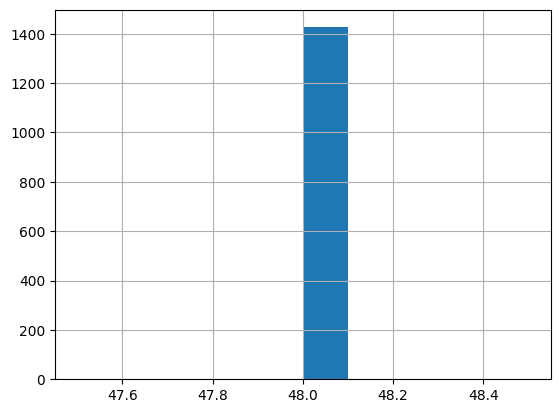

In [18]:
df_error['time_left'].hist(bins=10)

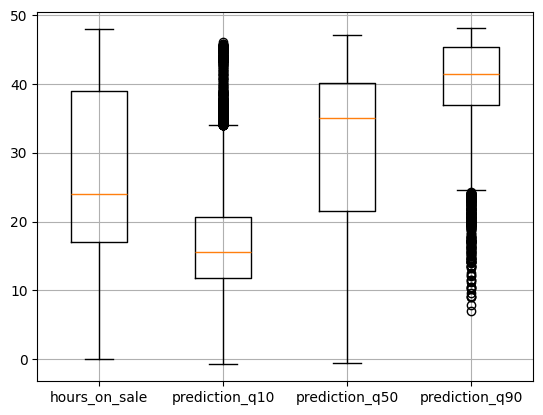

In [37]:
plt.boxplot(df_error[['hours_on_sale', 'prediction_q10', 'prediction_q50', 'prediction_q90']])
plt.xticks(ticks=[1,2,3,4], labels=['hours_on_sale', 'prediction_q10', 'prediction_q50', 'prediction_q90'])
plt.grid()
plt.show()

Mean error for hours 0-12: 19.23
Mean error for hours 12-24: 11.57
Mean error for hours 24-48: 5.81


/tmp/ipykernel_5541/979541771.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(error_by_bin, labels=labels)


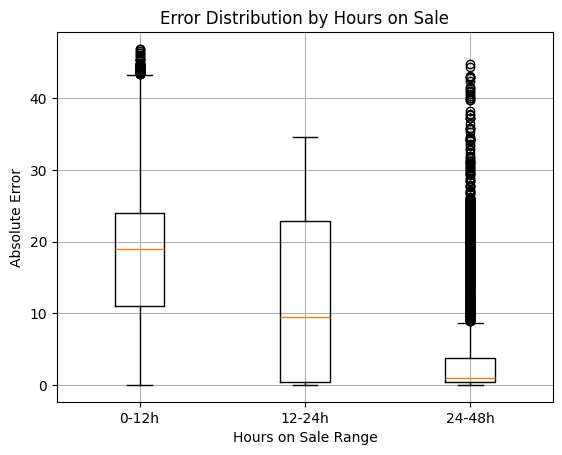

In [38]:
# Define bins for hours_on_sale
bins = [(0,12), (12,24), (24,48)]

# Calculate mean error for each bin
for start, end in bins:
    mask = (df_error['hours_on_sale'] >= start) & (df_error['hours_on_sale'] <= end)
    mean_error = df_error[mask]['error'].mean()
    print(f"Mean error for hours {start}-{end}: {mean_error:.2f}")

# Create boxplot showing error distribution in each bin
error_by_bin = []
labels = []
for start, end in bins:
    mask = (df_error['hours_on_sale'] >= start) & (df_error['hours_on_sale'] <= end)
    error_by_bin.append(df_error[mask]['error'])
    labels.append(f"{start}-{end}h")

plt.boxplot(error_by_bin, labels=labels)
plt.title("Error Distribution by Hours on Sale")
plt.ylabel("Absolute Error")
plt.xlabel("Hours on Sale Range") 
plt.grid()
plt.show()

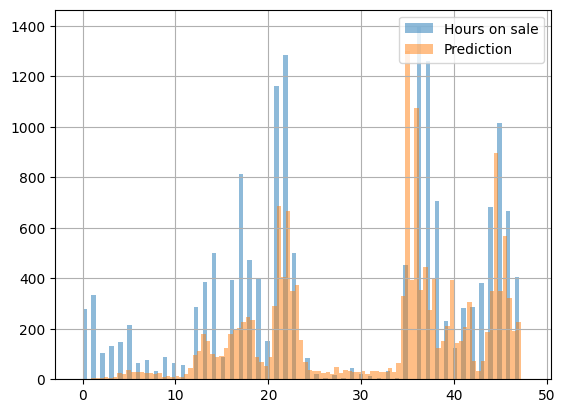

In [39]:
# histogram of hours on sale and prediction
plt.hist(df_error['hours_on_sale'], bins=100, alpha=0.5, label='Hours on sale')
plt.hist(df_error['prediction_q50'], bins=100, alpha=0.5, label='Prediction')
plt.legend(loc='upper right')
plt.grid()
plt.show()

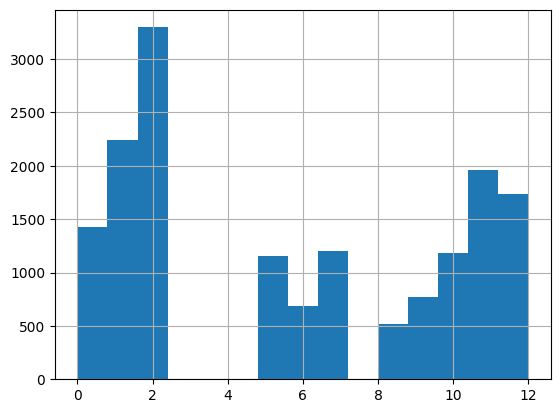

In [40]:
plt.hist(df_error['current_hours'], bins=15)
plt.grid()
plt.show()

We are interested in evaluating the model when the items are recently published, because this will be the main use case for the model

In [41]:
query = (df_error['current_hours'] <= 12) & (df_error['time_left'] == 48.0)
query_df = df_error[query]
print(f"Mean sale probability: {query_df['sale_probability'].mean()}")
print(f"Mean error: {query_df['error'].mean()}")
print(f"Mean hours on sale: {query_df['hours_on_sale'].mean()}")
query_df.sample(10)

Mean sale probability: 0.2524972156911273
Mean error: 9.44722744709813
Mean hours on sale: 27.95390421977478


,item_index,bid,buyout,quantity,time_left,first_appearance,last_appearance,current_hours,hours_on_sale,prediction_q10,prediction_q50,prediction_q90,sale_probability,error
63733,4979,0.0,2561.96,1,48.0,2025-09-09 08:00:00,2025-09-11 07:00:00,12.0,35.0,12.75,35.03,35.69,0.15,0.03
86262,4107,0.0,399.96,1,48.0,2025-09-09 18:00:00,2025-09-10 17:00:00,2.0,21.0,20.40,21.18,45.18,0.39,0.18
77001,5589,0.0,1226.98,1,48.0,2025-09-09 18:00:00,2025-09-11 16:00:00,2.0,44.0,19.84,44.00,44.79,0.16,0.00
66194,11157,0.0,23900.71,1,48.0,2025-09-09 08:00:00,2025-09-10 07:00:00,12.0,11.0,2.66,33.27,35.73,0.16,22.27
80688,17088,0.0,254.50,1,48.0,2025-09-09 15:00:00,2025-09-10 14:00:00,5.0,18.0,14.50,18.11,41.87,0.40,0.11
59321,263,0.0,1796.05,1,48.0,2025-09-09 11:00:00,2025-09-11 10:00:00,9.0,38.0,13.60,37.57,38.38,0.15,0.43
91276,7522,0.0,170.10,1,48.0,2025-09-09 19:00:00,2025-09-11 18:00:00,1.0,46.0,20.97,45.43,46.37,0.16,0.57
96035,9407,0.0,1111.07,1,48.0,2025-09-09 20:00:00,2025-09-11 19:00:00,0.0,47.0,22.72,46.59,47.15,0.15,0.41
50639,5446,0.0,237.97,1,48.0,2025-09-09 08:00:00,2025-09-11 07:00:00,12.0,35.0,34.18,35.05,35.90,0.15,0.05
8198,6980,0.0,29017.64,1,48.0,2025-09-09 15:00:00,2025-09-10 15:00:00,5.0,19.0,17.22,41.54,42.98,0.15,22.54


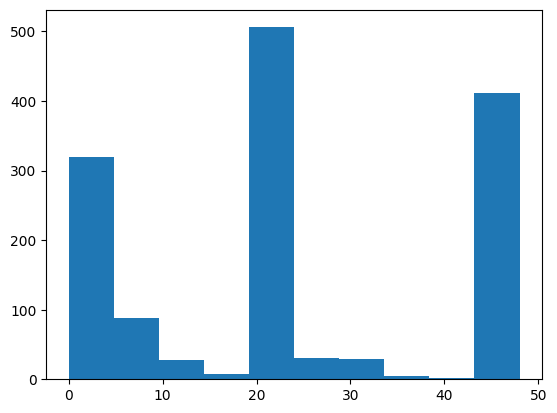

In [31]:
query_df['hours_on_sale'].hist(bins=10)
plt.grid()
plt.show()

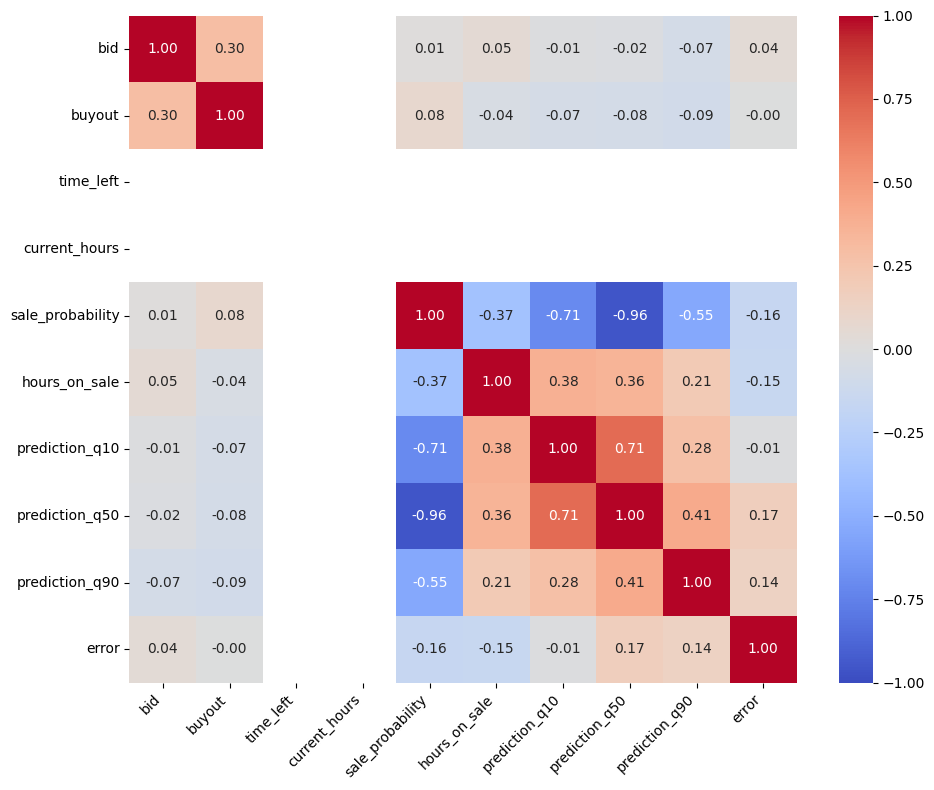

In [32]:
corr_matrix = df_error[['bid', 'buyout', 'time_left', 'current_hours', 'sale_probability',
                        'hours_on_sale', 'prediction_q10', 'prediction_q50', 'prediction_q90', 'error']].corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm',
            vmin=-1, vmax=1, 
            center=0,
            fmt='.2f',
            square=True) 

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()

plt.show()

# Eval validation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import sys
from tqdm import tqdm
from datetime import datetime
pd.options.mode.chained_assignment = None

from pathlib import Path

repo_root = Path.cwd().parent.resolve()
sys.path.append(str(repo_root))

from sklearn.model_selection import train_test_split
from src.data.auction_dataset import AuctionDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
pairs = pd.read_csv('../generated/auction_indices.csv')
pairs = pairs[pairs['g_hours_on_sale_max'] < 50]
pairs = pairs[pairs['g_current_hours_max'] < 50]

train_pairs, val_pairs = train_test_split(pairs, test_size=0.05, random_state=42, shuffle=False)

print(f"Before filtering: {len(train_pairs)}")

train_pairs = train_pairs[train_pairs['g_hours_on_sale_len'] <= 64]
val_pairs = val_pairs[val_pairs['g_hours_on_sale_len'] <= 64]

print(f"After filtering: {len(train_pairs)}\n")

train_pairs = train_pairs[:int(len(train_pairs)*0.85)]

print(f"Train pairs: {len(train_pairs)}")
print(f"Val pairs: {len(val_pairs)}")

In [ ]:
val_pairs = val_pairs[val_pairs['record'] == '2025-04-01 00:00:00']
val_pairs.head()

In [ ]:
import json
import os

mappings_dir = '../generated/mappings'

with open(os.path.join(mappings_dir, 'item_to_idx.json'), 'r') as f:
    item_to_idx = json.load(f)

with open(os.path.join(mappings_dir, 'context_to_idx.json'), 'r') as f:
    context_to_idx = json.load(f)
    
with open(os.path.join(mappings_dir, 'bonus_to_idx.json'), 'r') as f:
    bonus_to_idx = json.load(f)

with open(os.path.join(mappings_dir, 'modtype_to_idx.json'), 'r') as f:
    modtype_to_idx = json.load(f)

feature_stats = torch.load('../generated/feature_stats.pt')

In [ ]:
val_pairs.tail()

In [ ]:
from src.models.auction_transformer import AuctionTransformer

model = AuctionTransformer.load_from_checkpoint(
    '../models/auction_transformer_40M_39GB/last.ckpt',
    map_location=device
)

print(f'Number of model parameters: {sum(p.numel() for p in model.parameters())}')
model.eval()
print('Pre-trained Transformer model loaded successfully.')

In [ ]:
from src.data.auction_dataset import AuctionDataset
from src.data.utils import collate_auctions

batch_size = 1024

val_dataset = AuctionDataset(val_pairs, feature_stats=feature_stats, path='../generated/sequences.h5')
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_auctions) 

In [ ]:
"""
validate_and_noise.py
─────────────────────
Assumes you already have:

* model            – your trained AuctionTransformer (on `device`)
* val_dataloader   – torch DataLoader created from AuctionDataset
* feature_stats    – dict with 'means' and 'stds'  (torch tensors 1-D)
"""

import itertools
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm


# ───────────────────────────────────────────────────────────────────────────────
# 1. Helper: build a hashable signature of everything the network
#    can ACTUALLY distinguish once log1p+norm have been undone.
# ───────────────────────────────────────────────────────────────────────────────
def auction_signature(item_idx,
                      quantity,
                      buyout_gold,
                      context,
                      time_left,
                      current_hours,
                      bonus_lists,
                      modifier_types,
                      age_bucket=1.0):    # 1-hour buckets
    price_sig = round(float(buyout_gold), 2)          # 0.01 g precision
    age_sig   = int(current_hours // age_bucket)

    return (
        int(item_idx),
        int(quantity),
        price_sig,
        int(context),
        int(time_left),
        age_sig,
        tuple(sorted(bonus_lists)),
        tuple(sorted(modifier_types)),
    )


# ───────────────────────────────────────────────────────────────────────────────
# 2. Validation + noise-floor loop
# ───────────────────────────────────────────────────────────────────────────────
def evaluate_with_noise(model, val_loader, feature_stats, device="cuda"):
    means = feature_stats["means"].cpu().numpy()
    stds  = feature_stats["stds"].cpu().numpy()

    total_mse   = 0.0
    total_mae   = 0.0
    total_items = 0

    targets_by_sig = defaultdict(list)

    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            (auctions, item_index, contexts, bonus_lists,
             modifier_types, modifier_values, current_hours,
             time_left, buyout_ranking), y = batch

            # move to device ----------------------------------------------------
            auctions          = auctions.to(device)
            item_index        = item_index.to(device)
            contexts          = contexts.to(device)
            bonus_lists       = bonus_lists.to(device)
            modifier_types    = modifier_types.to(device)
            modifier_values   = modifier_values.to(device)
            current_hours     = current_hours.to(device)
            time_left         = time_left.to(device)
            buyout_ranking    = buyout_ranking.to(device)
            y                 = y.to(device)

            # forward -----------------------------------------------------------
            y_hat = model((auctions, item_index, contexts, bonus_lists,
                           modifier_types, modifier_values, buyout_ranking))

            # mask: real items, full 48 h left, listed ≤12 h ago -----------------
            mask  = (item_index != 0).float().unsqueeze(-1)
            #mask *= (time_left == 48.0).float().unsqueeze(-1)
            mask *= (current_hours <= 12.0).float().unsqueeze(-1)

            # losses ------------------------------------------------------------
            mse = torch.nn.functional.mse_loss(y_hat * mask,
                                               y.unsqueeze(2) * mask,
                                               reduction='sum')
            mae = torch.nn.functional.l1_loss(y_hat * mask * 48.0,
                                              y.unsqueeze(2) * mask * 48.0,
                                              reduction='sum')

            total_mse   += mse.item()
            total_mae   += mae.item()
            total_items += mask.sum().item()

            # ----- collect targets for irreducible-noise estimate --------------
            # work on CPU / numpy
            y_cpu            = (y * 48.0).cpu().numpy()
            mask_cpu         = mask.squeeze(-1).cpu().numpy()
            item_idx_cpu     = item_index.cpu().numpy()
            auctions_cpu     = auctions.cpu().numpy()        # z-scores
            contexts_cpu     = contexts.cpu().numpy()
            time_left_cpu    = time_left.cpu().numpy()
            current_hours_cpu= current_hours.cpu().numpy()
            bonus_lists_cpu  = bonus_lists.cpu().numpy()
            modifier_types_cpu = modifier_types.cpu().numpy()

            B, S, _ = auctions_cpu.shape
            for b in range(B):
                for s in range(S):
                    if not mask_cpu[b, s]:
                        continue

                    # -------- undo standardisation + log1p for price ------------
                    buyout_norm = auctions_cpu[b, s, 1]
                    log_buyout  = buyout_norm * stds[1] + means[1]
                    buyout_gold = np.expm1(log_buyout)

                    # quantity column is already linear but was standardised
                    qty_norm   = auctions_cpu[b, s, 2]
                    quantity   = int(round(qty_norm * stds[2] + means[2]))

                    sig = auction_signature(
                        item_idx_cpu[b, s],
                        quantity,
                        buyout_gold,
                        contexts_cpu[b, s],
                        time_left_cpu[b, s],
                        current_hours_cpu[b, s],
                        bonus_lists_cpu[b, s][bonus_lists_cpu[b, s] != 0],
                        modifier_types_cpu[b, s][modifier_types_cpu[b, s] != 0],
                    )

                    targets_by_sig[sig].append(float(y_cpu[b, s]))

    # ── aggregate --------------------------------------------------------------
    avg_mse = total_mse / total_items
    avg_mae = total_mae / total_items

    noise_sum   = 0.0
    noise_count = 0
    for t_list in targets_by_sig.values():
        if len(t_list) < 2:
            continue
        for a, b in itertools.combinations(t_list, 2):
            noise_sum   += abs(a - b)
            noise_count += 1

    irreducible_mae = noise_sum / noise_count if noise_count else 0.0

    print(f"Validation MSE          : {avg_mse:.4f}")
    print(f"Validation MAE          : {avg_mae:.4f} hours")
    print(f"Bayesian lower-bound MAE: {irreducible_mae:.4f} hours")

    return avg_mse, avg_mae, irreducible_mae

evaluate_with_noise(model, val_dataloader, feature_stats, device=device)

In [ ]:
from src.models.inference import predict_dataframe

predict_dataframe(model, df_auctions[df_auctions['item_index'] == 13815], prediction_time, feature_stats)